## Train and Evaulate Model

This notebook will train the model on the spectrogram input data and evaluate on the validation set 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import datetime

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Reshape, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Dropout, Input, Add, Masking, Conv2D, MaxPooling2D, Concatenate, BatchNormalization, Activation
from keras import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.utils.vis_utils import plot_model
import keras.backend as backend

Define some constants

In [3]:
BATCH_SIZE = 32

SPECTROGRAM_LEN = 19
SPECTROGRAM_FREQS = 101
NUM_OUTPUT_CLASSES = 3

CONV_OUTPUT_LEN = 200

Define a function to load in the train, test, and validation data. Note that all NREM stages are combined into a single class, so this becomes a 3 class classification problem

In [4]:
def load_data(data_group):
    data = pickle.load(open('X_%s_spec.pkl' % data_group, 'rb'))
    labels = pickle.load(open('y_%s.pkl' % data_group, 'rb'))

    #combine NREM1, NREM2, NREM3, and NREM4 into a single class
    #new class definitions:
    #Wake = 0 originally, this remains the same
    #N1 = 1, N2 = 2, N3 = 3, N4 = 4 originally, now they are all assigned to the label of 1
    #REM = 5 originally, now REM = 2
    #Artifact/Unlabeled: N/A as any such labels were already removed in spectrogram generation
    three_class_labels = []
    for label in labels:
        label = np.array(label)
        label_2_inds = np.where(label==2)[0]
        label_3_inds = np.where(label==3)[0]
        label_4_inds = np.where(label==4)[0]
        label_5_inds = np.where(label==5)[0]

        label[label_2_inds] = 1
        label[label_3_inds] = 1
        label[label_4_inds] = 1
        label[label_5_inds] = 2

        three_class_labels.append(label)

    X1 = []
    X2 = []
    X3 = []
    X4 = []
    X5 = []
    y = []
    for i in range(len(data)):
        X1_tmp = data[i][0]
        X2_tmp = data[i][1]
        X3_tmp = data[i][2]
        X4_tmp = data[i][3]
        X5_tmp = data[i][4]

        #make sure the size of the spectrogram is correct before adding it to the array
        #for some reason the third dimension of the spectrogram output is sometimes not right
        if (np.shape(X1_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X2_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X3_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X4_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X5_tmp)[2] != SPECTROGRAM_LEN):
            continue

        X1.append(X1_tmp)
        X2.append(X2_tmp)
        X3.append(X3_tmp)
        X4.append(X4_tmp)
        X5.append(X5_tmp)
        y.append(three_class_labels[i])


    X1 = np.array(X1).reshape(len(X1), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X2 = np.array(X2).reshape(len(X2), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X3 = np.array(X3).reshape(len(X3), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X4 = np.array(X4).reshape(len(X4), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X5 = np.array(X5).reshape(len(X5), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    y = to_categorical(y)

    return X1, X2, X3, X4, X5, y

Define a function to calculate the f1 score and confusion matrix

In [5]:
def performance_metrics(true, predictions, labels):

    #loop over each row, and then get the index corresponding to the max probability
    predictions_class = []
    for prediction in predictions:
        for row in prediction:
            predictions_class.append(np.argmax(row))

    #repeat for the true labels
    true_class = []
    for true_row in true:
        for row in true_row:
            true_class.append(np.argmax(row))

    #calculate confusion matrix
    conf_mat = confusion_matrix(true_class, predictions_class)
    conf_mat = pd.DataFrame(conf_mat, columns=labels, index=labels)

    #calculate per class f1
    f1 = f1_score(true_class, predictions_class, average=None)
    f1 = pd.Series(f1, index=labels)

    return conf_mat, f1, predictions_class, true_class

Load in the training and validation data

In [ ]:
X1_train, X2_train, X3_train, X4_train, X5_train, y_train = load_data('train')
X1_val, X2_val, X3_val, X4_val, X5_val, y_val = load_data('val')

Define the model architecture

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 101, 19, 2)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 101, 19, 2)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 101, 19, 2)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 101, 19, 2)] 0                                            
_______________________________________________________________________________________

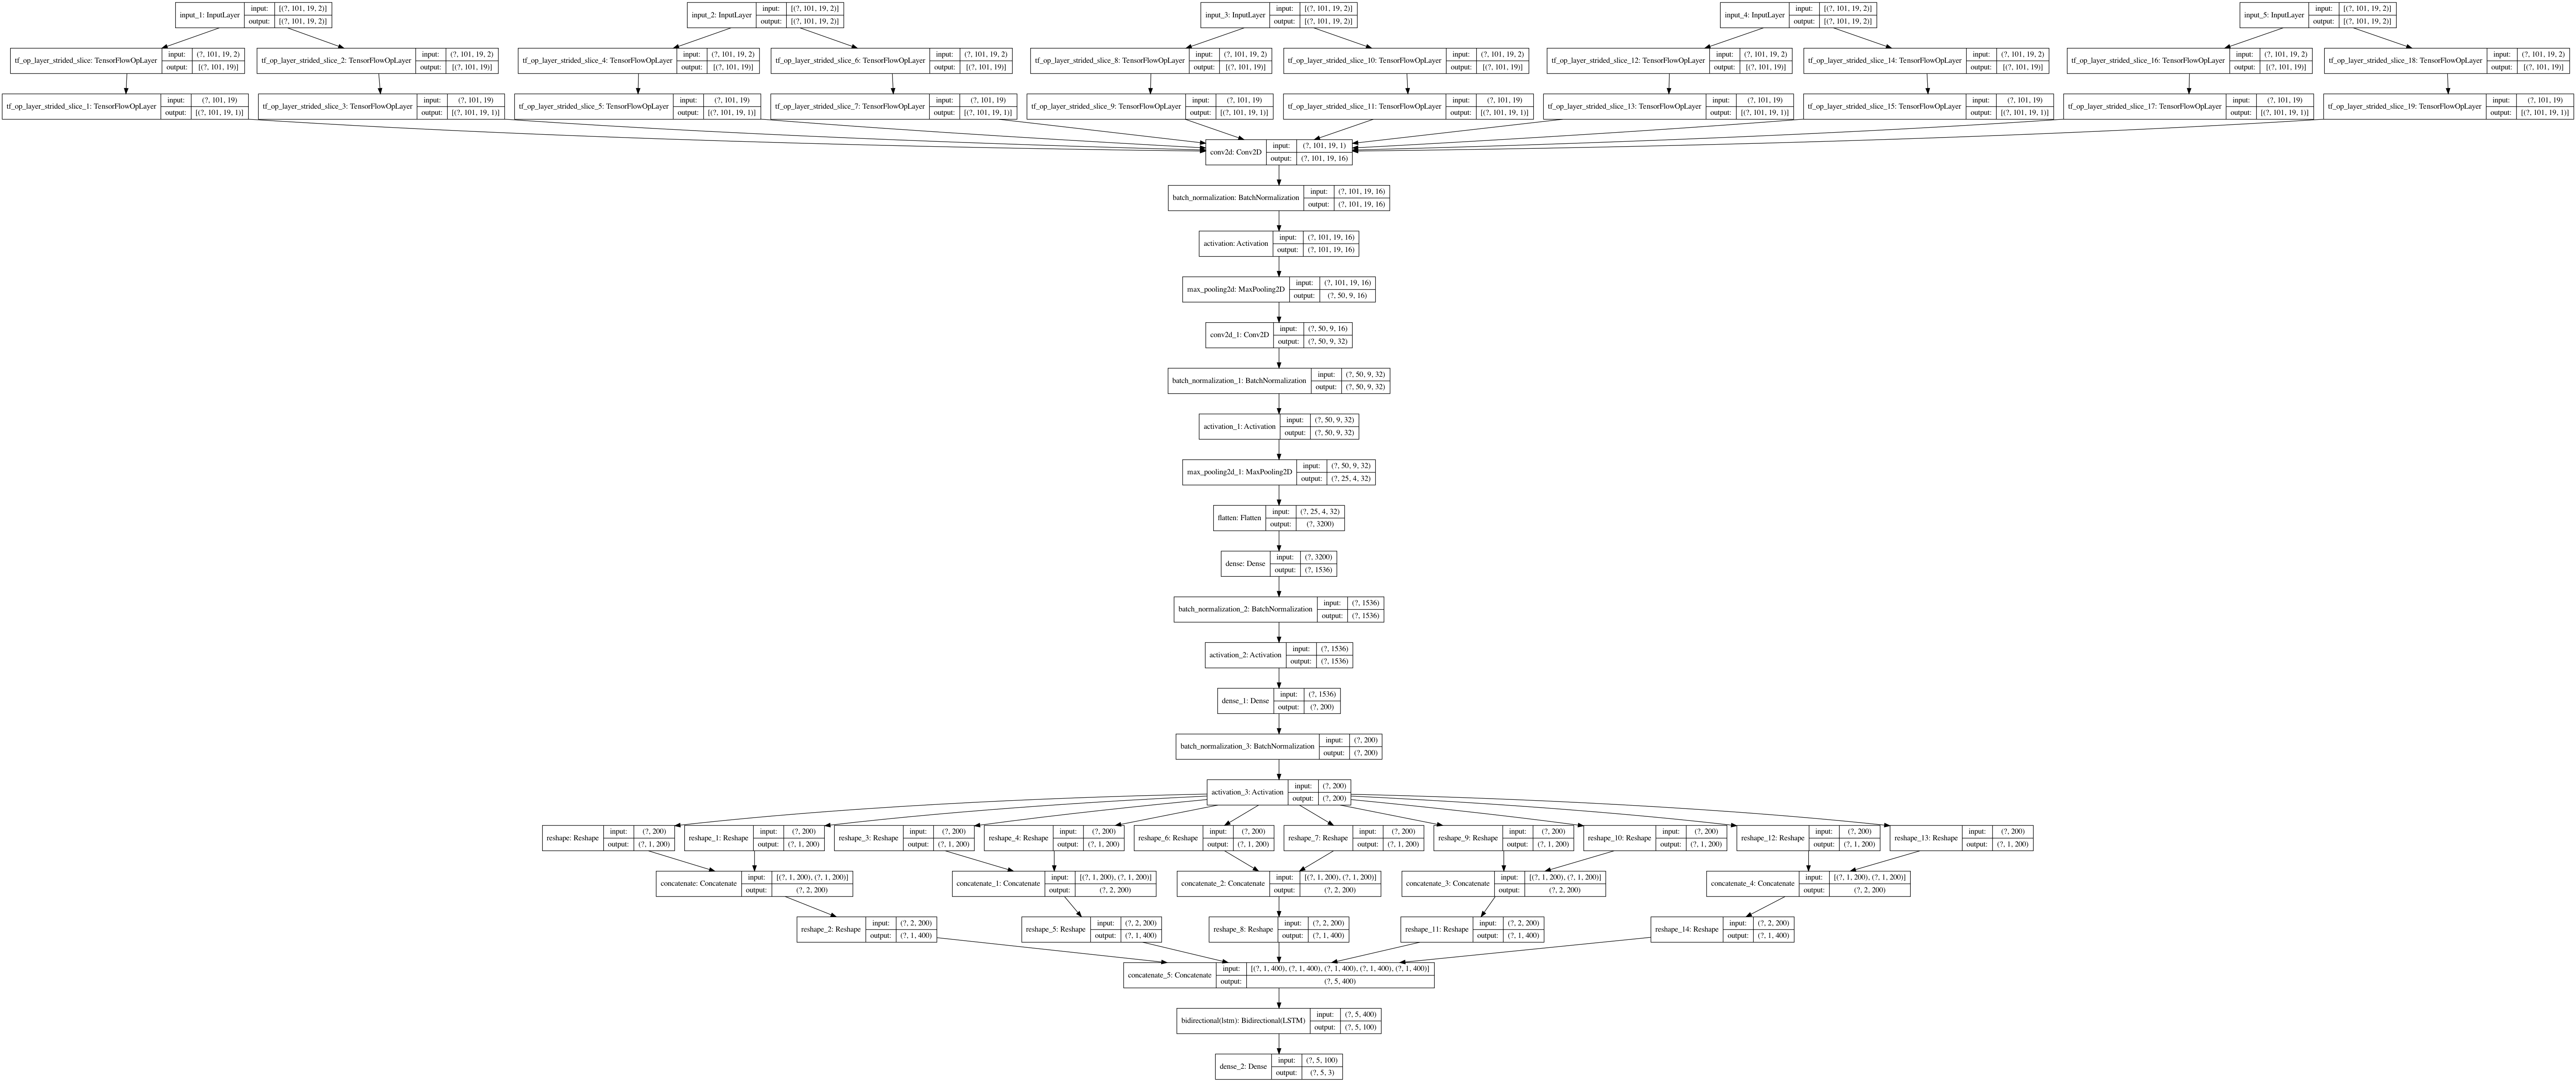

In [6]:
#shared layers
shared_cnn1 = Conv2D(filters=16, kernel_size=3, padding='same')
shared_batchnorm1 = BatchNormalization()
shared_relu1 = Activation('relu')
shared_cnn_maxpool1 = MaxPooling2D(pool_size=2,strides=2)

shared_cnn2 = Conv2D(filters=32, kernel_size=3, padding='same')
shared_batchnorm2 = BatchNormalization()
shared_relu2 = Activation('relu')
shared_cnn_maxpool2 = MaxPooling2D(pool_size=2,strides=2)

shared_cnn_flatten = Flatten()
shared_cnn_dense = Dense(units=1536)
shared_batchnorm3 = BatchNormalization()
shared_relu3 = Activation('relu')

shared_cnn_output = Dense(CONV_OUTPUT_LEN)
shared_batchnorm4 = BatchNormalization()
shared_relu4 = Activation('relu')

#five inputs for the five 30-second blocks
input1 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input2 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input3 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input4 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input5 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))

#FIRST 30 SECOND BLOCK
#first channel
cnn_output11 = shared_cnn1(input1[:,:,:,0][...,None])
cnn_output11 = shared_batchnorm1(cnn_output11)
cnn_output11 = shared_relu1(cnn_output11)
cnn_output11 = shared_cnn_maxpool1(cnn_output11)
cnn_output11 = shared_cnn2(cnn_output11)
cnn_output11 = shared_batchnorm2(cnn_output11)
cnn_output11 = shared_relu2(cnn_output11)
cnn_output11 = shared_cnn_maxpool2(cnn_output11)
cnn_output11 = shared_cnn_flatten(cnn_output11)
cnn_output11 = shared_cnn_dense(cnn_output11)
cnn_output11 = shared_batchnorm3(cnn_output11)
cnn_output11 = shared_relu3(cnn_output11)
cnn_output11 = shared_cnn_output(cnn_output11)
cnn_output11 = shared_batchnorm4(cnn_output11)
cnn_output11 = shared_relu4(cnn_output11)
cnn_output11 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output11)

#second channel
cnn_output12 = shared_cnn1(input1[:,:,:,1][...,None])
cnn_output12 = shared_batchnorm1(cnn_output12)
cnn_output12 = shared_relu1(cnn_output12)
cnn_output12 = shared_cnn_maxpool1(cnn_output12)
cnn_output12 = shared_cnn2(cnn_output12)
cnn_output12 = shared_batchnorm2(cnn_output12)
cnn_output12 = shared_relu2(cnn_output12)
cnn_output12 = shared_cnn_maxpool2(cnn_output12)
cnn_output12 = shared_cnn_flatten(cnn_output12)
cnn_output12 = shared_cnn_dense(cnn_output12)
cnn_output12 = shared_batchnorm3(cnn_output12)
cnn_output12 = shared_relu3(cnn_output12)
cnn_output12 = shared_cnn_output(cnn_output12)
cnn_output12 = shared_batchnorm4(cnn_output12)
cnn_output12 = shared_relu4(cnn_output12)
cnn_output12 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output12)

#concatenate each channel's output
cnn_output1 = Concatenate(axis=1)([cnn_output11, cnn_output12])
cnn_output1 = Reshape((1,CONV_OUTPUT_LEN*2))(cnn_output1)


#SECOND 30 SECOND BLOCK
#first channel
cnn_output21 = shared_cnn1(input2[:,:,:,0][...,None])
cnn_output21 = shared_batchnorm1(cnn_output21)
cnn_output21 = shared_relu1(cnn_output21)
cnn_output21 = shared_cnn_maxpool1(cnn_output21)
cnn_output21 = shared_cnn2(cnn_output21)
cnn_output21 = shared_batchnorm2(cnn_output21)
cnn_output21 = shared_relu2(cnn_output21)
cnn_output21 = shared_cnn_maxpool2(cnn_output21)
cnn_output21 = shared_cnn_flatten(cnn_output21)
cnn_output21 = shared_cnn_dense(cnn_output21)
cnn_output21 = shared_batchnorm3(cnn_output21)
cnn_output21 = shared_relu3(cnn_output21)
cnn_output21 = shared_cnn_output(cnn_output21)
cnn_output21 = shared_batchnorm4(cnn_output21)
cnn_output21 = shared_relu4(cnn_output21)
cnn_output21 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output21)

#second channel
cnn_output22 = shared_cnn1(input2[:,:,:,1][...,None])
cnn_output22 = shared_batchnorm1(cnn_output22)
cnn_output22 = shared_relu1(cnn_output22)
cnn_output22 = shared_cnn_maxpool1(cnn_output22)
cnn_output22 = shared_cnn2(cnn_output22)
cnn_output22 = shared_batchnorm2(cnn_output22)
cnn_output22 = shared_relu2(cnn_output22)
cnn_output22 = shared_cnn_maxpool2(cnn_output22)
cnn_output22 = shared_cnn_flatten(cnn_output22)
cnn_output22 = shared_cnn_dense(cnn_output22)
cnn_output22 = shared_batchnorm3(cnn_output22)
cnn_output22 = shared_relu3(cnn_output22)
cnn_output22 = shared_cnn_output(cnn_output22)
cnn_output22 = shared_batchnorm4(cnn_output22)
cnn_output22 = shared_relu4(cnn_output22)
cnn_output22 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output22)

#concatenate each channel's output
cnn_output2 = Concatenate(axis=1)([cnn_output21, cnn_output22])
cnn_output2 = Reshape((1,CONV_OUTPUT_LEN*2))(cnn_output2)


#THIRD 30 SECOND BLOCK
#first channel
cnn_output31 = shared_cnn1(input3[:,:,:,0][...,None])
cnn_output31 = shared_batchnorm1(cnn_output31)
cnn_output31 = shared_relu1(cnn_output31)
cnn_output31 = shared_cnn_maxpool1(cnn_output31)
cnn_output31 = shared_cnn2(cnn_output31)
cnn_output31 = shared_batchnorm2(cnn_output31)
cnn_output31 = shared_relu2(cnn_output31)
cnn_output31 = shared_cnn_maxpool2(cnn_output31)
cnn_output31 = shared_cnn_flatten(cnn_output31)
cnn_output31 = shared_cnn_dense(cnn_output31)
cnn_output31 = shared_batchnorm3(cnn_output31)
cnn_output31 = shared_relu3(cnn_output31)
cnn_output31 = shared_cnn_output(cnn_output31)
cnn_output31 = shared_batchnorm4(cnn_output31)
cnn_output31 = shared_relu4(cnn_output31)
cnn_output31 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output31)

#second channel
cnn_output32 = shared_cnn1(input3[:,:,:,1][...,None])
cnn_output32 = shared_batchnorm1(cnn_output32)
cnn_output32 = shared_relu1(cnn_output32)
cnn_output32 = shared_cnn_maxpool1(cnn_output32)
cnn_output32 = shared_cnn2(cnn_output32)
cnn_output32 = shared_batchnorm2(cnn_output32)
cnn_output32 = shared_relu2(cnn_output32)
cnn_output32 = shared_cnn_maxpool2(cnn_output32)
cnn_output32 = shared_cnn_flatten(cnn_output32)
cnn_output32 = shared_cnn_dense(cnn_output32)
cnn_output32 = shared_batchnorm3(cnn_output32)
cnn_output32 = shared_relu3(cnn_output32)
cnn_output32 = shared_cnn_output(cnn_output32)
cnn_output32 = shared_batchnorm4(cnn_output32)
cnn_output32 = shared_relu4(cnn_output32)
cnn_output32 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output32)

#concatenate each channel's output
cnn_output3 = Concatenate(axis=1)([cnn_output31, cnn_output32])
cnn_output3 = Reshape((1,CONV_OUTPUT_LEN*2))(cnn_output3)


#FOURTH 30 SECOND BLOCK
#first channel
cnn_output41 = shared_cnn1(input4[:,:,:,0][...,None])
cnn_output41 = shared_batchnorm1(cnn_output41)
cnn_output41 = shared_relu1(cnn_output41)
cnn_output41 = shared_cnn_maxpool1(cnn_output41)
cnn_output41 = shared_cnn2(cnn_output41)
cnn_output41 = shared_batchnorm2(cnn_output41)
cnn_output41 = shared_relu2(cnn_output41)
cnn_output41 = shared_cnn_maxpool2(cnn_output41)
cnn_output41 = shared_cnn_flatten(cnn_output41)
cnn_output41 = shared_cnn_dense(cnn_output41)
cnn_output41 = shared_batchnorm3(cnn_output41)
cnn_output41 = shared_relu3(cnn_output41)
cnn_output41 = shared_cnn_output(cnn_output41)
cnn_output41 = shared_batchnorm4(cnn_output41)
cnn_output41 = shared_relu4(cnn_output41)
cnn_output41 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output41)

#second channel
cnn_output42 = shared_cnn1(input4[:,:,:,1][...,None])
cnn_output42 = shared_batchnorm1(cnn_output42)
cnn_output42 = shared_relu1(cnn_output42)
cnn_output42 = shared_cnn_maxpool1(cnn_output42)
cnn_output42 = shared_cnn2(cnn_output42)
cnn_output42 = shared_batchnorm2(cnn_output42)
cnn_output42 = shared_relu2(cnn_output42)
cnn_output42 = shared_cnn_maxpool2(cnn_output42)
cnn_output42 = shared_cnn_flatten(cnn_output42)
cnn_output42 = shared_cnn_dense(cnn_output42)
cnn_output42 = shared_batchnorm3(cnn_output42)
cnn_output42 = shared_relu3(cnn_output42)
cnn_output42 = shared_cnn_output(cnn_output42)
cnn_output42 = shared_batchnorm4(cnn_output42)
cnn_output42 = shared_relu4(cnn_output42)
cnn_output42 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output42)

#concatenate each channel's output
cnn_output4 = Concatenate(axis=1)([cnn_output41, cnn_output42])
cnn_output4 = Reshape((1,CONV_OUTPUT_LEN*2))(cnn_output4)


#FIFTH 30 SECOND BLOCK
#first channel
cnn_output51 = shared_cnn1(input5[:,:,:,0][...,None])
cnn_output51 = shared_batchnorm1(cnn_output51)
cnn_output51 = shared_relu1(cnn_output51)
cnn_output51 = shared_cnn_maxpool1(cnn_output51)
cnn_output51 = shared_cnn2(cnn_output51)
cnn_output51 = shared_batchnorm2(cnn_output51)
cnn_output51 = shared_relu2(cnn_output51)
cnn_output51 = shared_cnn_maxpool2(cnn_output51)
cnn_output51 = shared_cnn_flatten(cnn_output51)
cnn_output51 = shared_cnn_dense(cnn_output51)
cnn_output51 = shared_batchnorm3(cnn_output51)
cnn_output51 = shared_relu3(cnn_output51)
cnn_output51 = shared_cnn_output(cnn_output51)
cnn_output51 = shared_batchnorm4(cnn_output51)
cnn_output51 = shared_relu4(cnn_output51)
cnn_output51 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output51)

#second channel
cnn_output52 = shared_cnn1(input5[:,:,:,1][...,None])
cnn_output52 = shared_batchnorm1(cnn_output52)
cnn_output52 = shared_relu1(cnn_output52)
cnn_output52 = shared_cnn_maxpool1(cnn_output52)
cnn_output52 = shared_cnn2(cnn_output52)
cnn_output52 = shared_batchnorm2(cnn_output52)
cnn_output52 = shared_relu2(cnn_output52)
cnn_output52 = shared_cnn_maxpool2(cnn_output52)
cnn_output52 = shared_cnn_flatten(cnn_output52)
cnn_output52 = shared_cnn_dense(cnn_output52)
cnn_output52 = shared_batchnorm3(cnn_output52)
cnn_output52 = shared_relu3(cnn_output52)
cnn_output52 = shared_cnn_output(cnn_output52)
cnn_output52 = shared_batchnorm4(cnn_output52)
cnn_output52 = shared_relu4(cnn_output52)
cnn_output52 = Reshape((1,CONV_OUTPUT_LEN))(cnn_output52)

#concatenate each channel's output
cnn_output5 = Concatenate(axis=1)([cnn_output51, cnn_output52])
cnn_output5 = Reshape((1,CONV_OUTPUT_LEN*2))(cnn_output5)

#combine all five outputs into a single input for the LSTM
cnn_concat = Concatenate(axis=1)([cnn_output1, cnn_output2, cnn_output3, cnn_output4, cnn_output5])

lstm_output = Bidirectional(LSTM(50, return_sequences=True))(cnn_concat)
lstm_output = Dense(NUM_OUTPUT_CLASSES, activation='softmax')(lstm_output)

model = Model(inputs=[input1, input2, input3, input4, input5], outputs=lstm_output)
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='rmsprop')

print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Train the model

In [8]:
#change this to true to train the model again
if False:
    checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='rmsprop')
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
    history = model.fit([X1_train, X2_train, X3_train, X4_train, X5_train],
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=100,
                        validation_data=([X1_val, X2_val, X3_val, X4_val, X5_val], y_val),
                        callbacks=[earlystop, checkpoint, CSVLogger('history.csv')],
                        verbose=1)


model = load_model('model.h5')
history = pd.read_csv('history.csv')

Plot the loss and accuracy. Note that early stopping saved the model after epoch 4, so here only up to epoch 4 is plotted

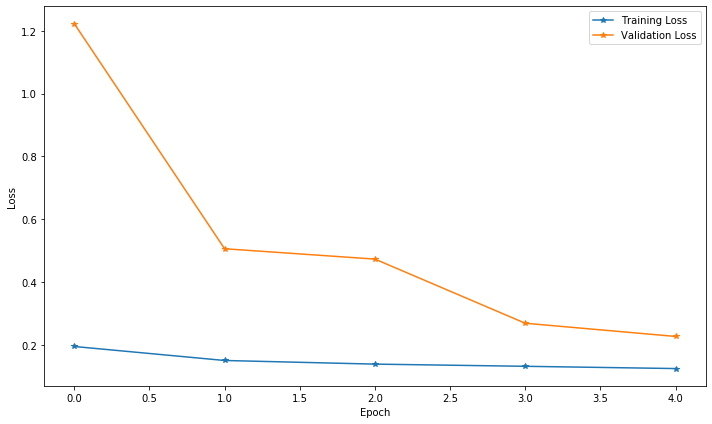

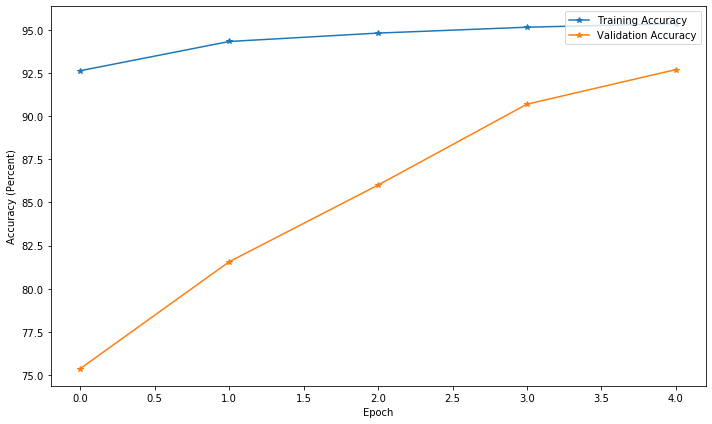

In [23]:
#plot the training and validation loss
plt.subplots(figsize=(10,6))
plt.plot(history['loss'][0:5], '*-', label='Training Loss')
plt.plot(history['val_loss'][0:5], '*-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('loss.png', dpi=150)
plt.show()

#plot the training and validation accuracy
plt.subplots(figsize=(10,6))
plt.plot(history['categorical_accuracy'][0:5]*100, '*-', label='Training Accuracy')
plt.plot(history['val_categorical_accuracy'][0:5]*100, '*-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Percent)')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('accuracy.png', dpi=150)
plt.show()

Evaluate the model on the test set

In [20]:
X1_test, X2_test, X3_test, X4_test, X5_test, y_test = load_data('test')
predictions = model.predict([X1_test, X2_test, X3_test, X4_test, X5_test])

#calculate confusion matrix and f1 scores
conf_mat, f1, _, _ = performance_metrics(y_test, predictions, ['Wake', 'NREM', 'REM'])

print('Confusion Matrix:')
print(conf_mat)

print('\nf1 score, per class:')
print(f1)

Confusion Matrix:
       Wake   NREM   REM
Wake  57820    769   318
NREM   1481  23989  1880
REM     281   1443  4834

f1 score, per class:
Wake    0.975956
NREM    0.895931
REM     0.711405
dtype: float64


Generate an example output hypnogram and compare against the true values. This corresponds to subject SC4121EC from the test set.

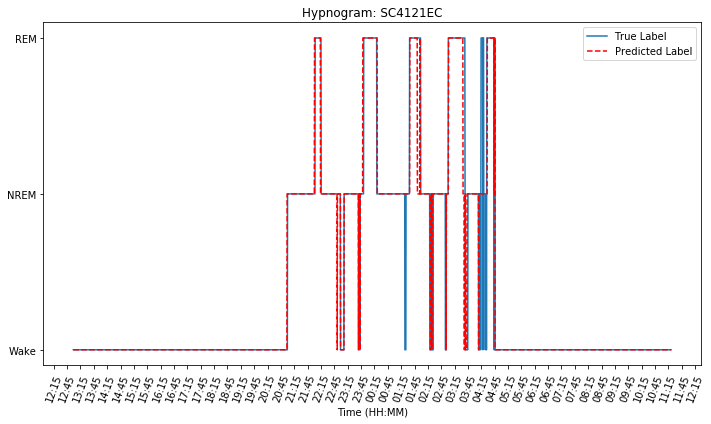

In [22]:
#get the predicted hypnogram for test set subject SC4121EC
X1_SC4121EC, X2_SC4121EC, X3_SC4121EC, X4_SC4121EC, X5_SC4121EC, y_SC4121EC = load_data('SC4121EC')
predictions = model.predict([X1_SC4121EC, X2_SC4121EC, X3_SC4121EC, X4_SC4121EC, X5_SC4121EC])

_, _, predictions_class, true_class = performance_metrics(y_SC4121EC, predictions, ['Wake', 'NREM', 'REM'])
fig, ax = plt.subplots(figsize=(10,6))
zero_time = datetime.datetime(2021,1,1,12,59,0)
timestamps = np.array([zero_time+datetime.timedelta(seconds=i*30) for i in range(len(predictions_class))])
plt.plot(timestamps, true_class, label='True Label')
plt.plot(timestamps, predictions_class, 'r--', label='Predicted Label')
plt.legend(loc=1)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=70)
ax.set_yticks([0,1,2])
ax.set_yticklabels(['Wake', 'NREM', 'REM'])
plt.xlabel('Time (HH:MM)')
plt.title('Hypnogram: SC4121EC')
plt.tight_layout()
plt.savefig('SC4121EC_hypnogram.png', dpi=250)
plt.show()